# Segmentação Semântica em Fácies Sísmicas

Aluno: Gabriel Lima Nunes

Matrícula: 2021032048

## Imports

In [9]:
import os
import numpy as np
import tensorflow as tf
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from keras_unet_collection import models


In [10]:
DATA_FOLDER_PATH='/scratch/nunes/seismic/' #Pasta onde o dataset será salvo
#Os seguintes parâmetros são utilizados somente para organizar onde são salvos os checkpoints e resultados do modelo
FOLDER_NAME="parihaka" 
NAME="unet"

## Introdução

Nesse trabalho iremos explorar uma área do Aprendizado de Máquina que não foi explorado muito durante a disciplina mas que utiliza diversos conceitos e estratégias que discutimos durante as aulas.

A Segmentação Semântica é uma tarefa de visão computacional em que atribuimos uma classe para cada um dos pixels presentes em uma imagem por meio de modelos de Deep Learning. Nesse trabalho, o modelo utilizado será uma UNet, que será descrita melhor nas seções seguintes, e o dataset escolhido é de fases sísmicas na Nova Zelândia.

Além de explorar as capacidades do nosso modelo para essa tarefa desejamos entender o motivo de suas escolhas, para isso iremos aplicar o método de explicabilidade Grad-Cam, de modo a gerar um mapa de calor para cada uma das classes.

## Dataset


### Descrição dos Dados

O dataset escolhido consiste em imagens sísmicas de estruturas subterrâneas feitas durante a exploração e desenvolvimento de reservatórios suberrâneos, por meio do envio de ondas sonoras e gravação dos ecos que retornam a superfície, de forma semelhante a ultrasons médicos. Cada pixel da imagem desse modo representa uma área de 25mx25m, com 10m de profundidade.

Nosso dataset em específico é proveniente de uma imagem sísmica 3D disponível publicamente pelo governo da Nova Zelândia, chamado Parihaka, e que foi interpretado e anotado por geologistas. Esse dado é dividido em seis classes representando fácies geológicas:

1. Basement/Other
2. Slope Mudstone A
3. Mass Transport Deposit
4. Slope Mudstone B
5. Slope Valley
6. Submarine Canyon System

O dado utilizado possui dimensões 1006 × 782 × 590, e foi escolhido para essa tarefa de segmentação devido ao alto custo da anotação manual dos dados de exploração sísmica, com depêndencia de geologistas especializados, e a possibilidade de expandirmos os métodos utilizados aqui para outras tarefas de segmentação dentro da geologia
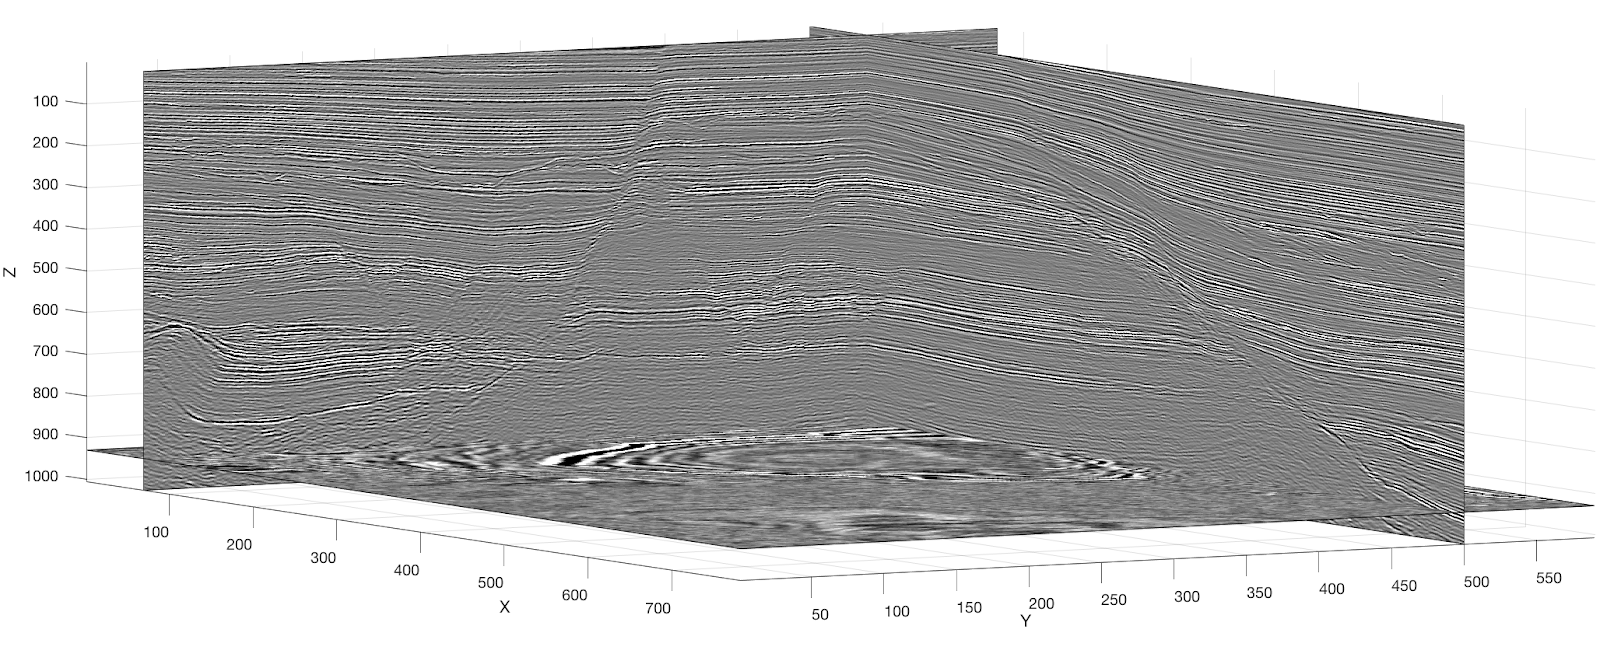
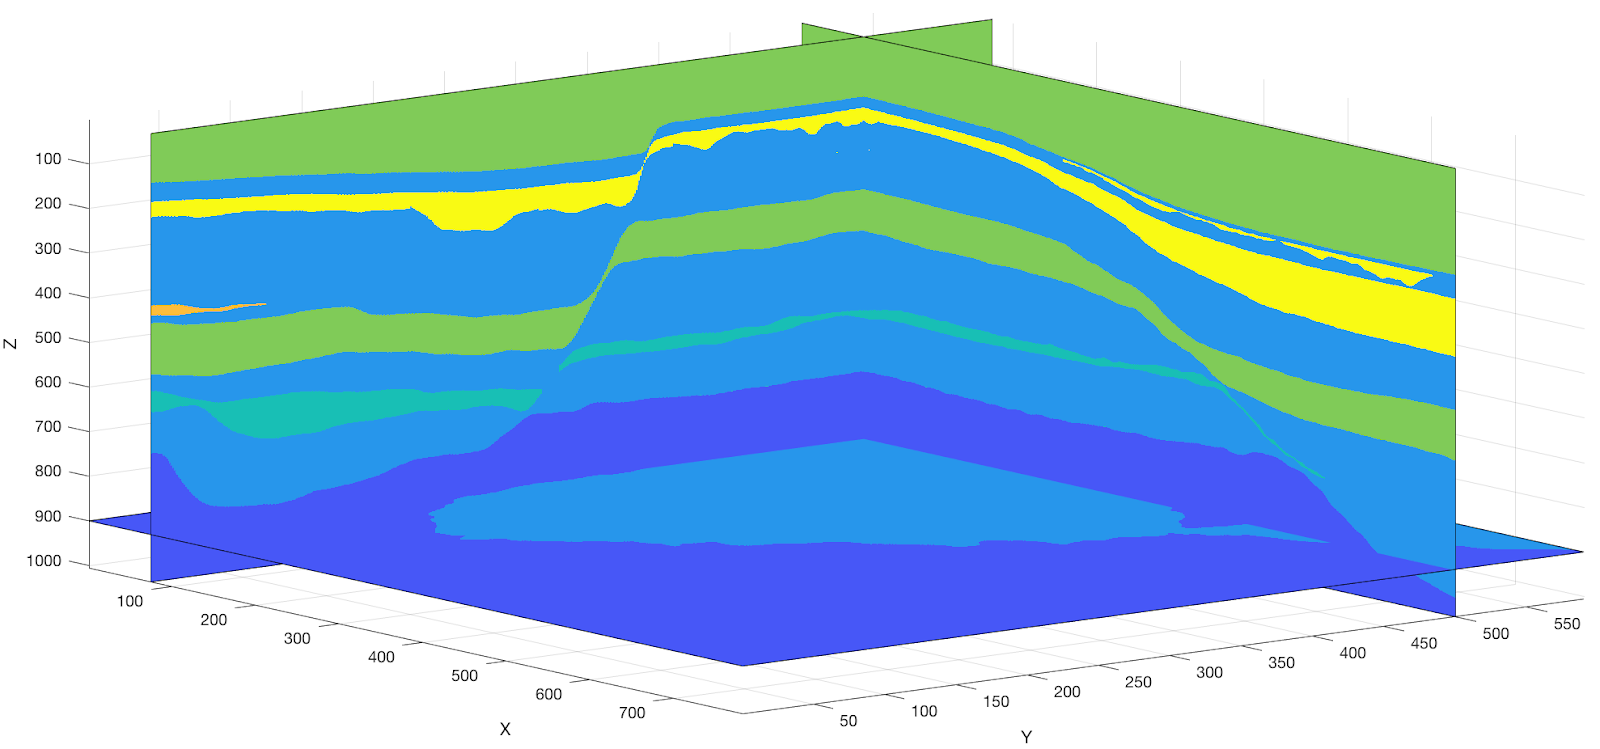

### Funções Auxiliares

In [11]:
def extract_patches(input_array, patch_shape, stride):
    patches = []
    rows, cols = input_array.shape
    patch_rows, patch_cols = patch_shape
    row_stride, col_stride = stride
    
    for r in range(0, rows - patch_rows + 1, row_stride):
        for c in range(0, cols - patch_cols + 1, col_stride):
            patch = input_array[r:r + patch_rows, c:c + patch_cols]
            patches.append(patch)
    
    return patches

def scale_to_256(array):
    min_val = np.min(array)
    max_val = np.max(array)

    # Scale the array to the range [0, 255]
    scaled_array = ((array - min_val) / (max_val - min_val)) * 255

    # Round to integers
    scaled_array = scaled_array.astype(np.uint8)

    return scaled_array    

def data_distribution():
    read_labels = np.load(DATA_FOLDER_PATH + 'labels_train.npz', allow_pickle=True, mmap_mode='r')

    # Acessar os dados dentro do arquivo npz
    labels = read_labels['labels']
    labels[labels==6] = 0
    
    # Contar a frequência de cada classe
    unique, counts = np.unique(labels, return_counts=True)

    # Calcular o percentual de cada classe
    percentages = 100 * counts / counts.sum()

    # Gerar o gráfico de pizza
    plt.figure(figsize=(8, 8))
    plt.pie(percentages, labels=unique, autopct='%1.1f%%', startangle=140)
    plt.title('Distribuição de Classes')
    plt.axis('equal')
    plt.show()

def my_division_data(shape=(992,192),stridetest=(128,64), strideval=(128,64), stridetrain=(128,64)):
    read_seis_data = np.load(
        DATA_FOLDER_PATH+'data_train.npz', 
                allow_pickle=True, mmap_mode = 'r')
    # We read our labels
    read_labels = np.load(
        DATA_FOLDER_PATH+'labels_train.npz',
                    allow_pickle=True, mmap_mode = 'r')

    # Inside the elements we pick what we are interesed in
    seis_data = read_seis_data['data']
    seis_data=scale_to_256(seis_data)
    labels = read_labels['labels']
    labels[labels==6] = 0

    testcrossline=seis_data[:,702:782,:]
    testinline=seis_data[:,:702,510:590]
    testcrossline_label=labels[:,702:782,:]
    testinline_label=labels[:,:702,510:590]

    #removing the test data the rest of our data has shape Z=1006 X=702 Y=510
    valcrossline=seis_data[:,622:702,:510]
    valinline=seis_data[:,:622,430:510]
    valcrossline_label=labels[:,622:702,:510]
    valinline_label=labels[:,:622,430:510]

    ##removing the validation data the rest of our data has shape Z=1006 X=622 Y=430
    traindata=seis_data[:,:622,:430]
    trainlabel=labels[:,:622,:430]


    #TRAINING
    trainpatches=[]
    trainlabels=[]
    for i in (range(traindata.shape[2])):
        trainpatches=trainpatches+extract_patches(traindata[:,:,i],(shape),(stridetrain))
        trainlabels=trainlabels+extract_patches(trainlabel[:,:,i],(shape),(stridetrain))
    for i in (range(traindata.shape[1])):
        trainpatches=trainpatches+extract_patches(traindata[:,i,:],(shape),(stridetrain))
        trainlabels=trainlabels+extract_patches(trainlabel[:,i,:],(shape),(stridetrain))
    trainslices=np.array(trainpatches)
    trainlabels=np.array(trainlabels)

    #VALIDATION
    valpatches=[]
    vallabels=[]
    for i in (range(valinline.shape[2])):
        valpatches=valpatches+extract_patches(valinline[:,:,i],(shape),(strideval))
        vallabels=vallabels+extract_patches(valinline_label[:,:,i],(shape),(strideval))
    for i in (range(valcrossline.shape[1])):
        valpatches=valpatches+extract_patches(valcrossline[:,i,:],(shape),(strideval))
        vallabels=vallabels+extract_patches(valcrossline_label[:,i,:],(shape),(strideval))
    valslices=np.array(valpatches)
    vallabels=np.array(vallabels)

    #TEST
    testpatches=[]
    testlabels=[]
    for i in (range(testinline.shape[2])):
        testpatches=testpatches+extract_patches(testinline[:,:,i],(shape),(stridetest))
        testlabels=testlabels+extract_patches(testinline_label[:,:,i],(shape),(stridetest))
    for i in (range(testcrossline.shape[1])):
        testpatches=testpatches+extract_patches(testcrossline[:,i,:],(shape),(stridetest))
        testlabels=testlabels+extract_patches(testcrossline_label[:,i,:],(shape),(stridetest))
    testslices=np.array(testpatches)
    testlabels=np.array(testlabels)

    return trainslices, trainlabels, testslices, testlabels, valslices, vallabels


def show_data_division():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.imshow(np.ones([782,590]), cmap='gray', alpha=0.5)

    # Train data
    rect = patches.Rectangle((0, 0), 430, 622, linewidth=2, edgecolor='g', facecolor='g', alpha=0.5)
    ax.add_patch(rect)

    # Validation data
    rect = patches.Rectangle((430, 0), 80, 622, linewidth=2, edgecolor='none', facecolor='b', alpha=0.5)
    ax.add_patch(rect)

    rect = patches.Rectangle((0, 622), 510, 80, linewidth=2, edgecolor='none', facecolor='b', alpha=0.5)
    ax.add_patch(rect)

    # Test data
    rect = patches.Rectangle((510, 0), 80, 702, linewidth=2, edgecolor='none', facecolor='r', alpha=0.5)
    ax.add_patch(rect)

    rect = patches.Rectangle((0, 702), 590, 80, linewidth=2, edgecolor='none', facecolor='r', alpha=0.5)
    ax.add_patch(rect)

    # Add legend
    train_patch = patches.Patch(color='g', label='Training')
    val_patch = patches.Patch(color='b', label='Validation')
    test_patch = patches.Patch(color='r', label='Test')
    ax.legend(handles=[train_patch, val_patch, test_patch], loc='upper right')

    ax.set_xlim(0, 590)
    ax.set_ylim(782, 0)
    ax.set_title('Data Division')
    plt.show()

### Carregar Dataset

Nossos dados foram adquiridos por meio do site AIcrowd onde realizaram um [desafio de segmentação semântica](https://www.aicrowd.com/challenges/seismic-facies-identification-challenge) com esse dataset. Assim, é possível baixarmos por meio desse [site](https://www.aicrowd.com/challenges/seismic-facies-identification-challenge/dataset_files) as fácies sísmicas (data_train.npz) com que iremos trabalhar, assim como as máscaras anotadas (labels_train.npz)

In [12]:
slice_shape1=992
slice_shape2=192
stride=(128,64)
num_classes=6

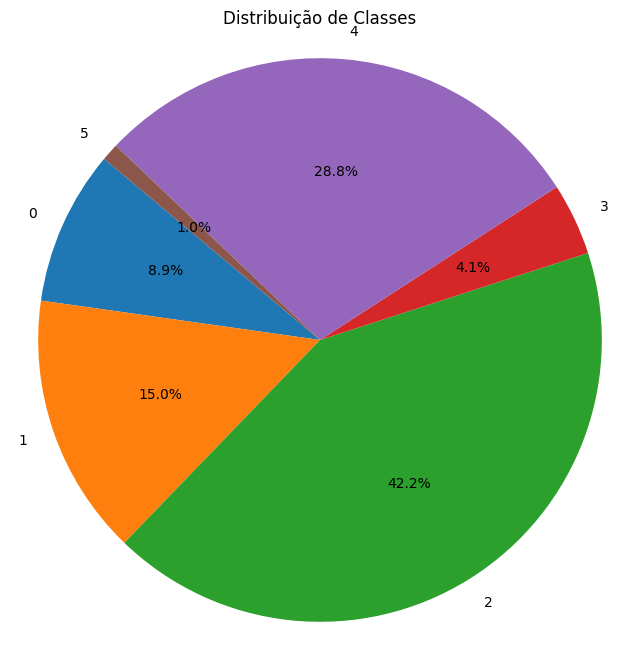

In [13]:
data_distribution()

O dado anotado disponibilizado consiste em uma imagem 3D com dimensões de (1006 x 782 x 590) em que realizarmos nossas análises. Para utilizarmos essa imagem no nosso treinamento e futuras análises, dividimos ela em treino, teste e validação, com as seguintes distribuições:

- Treino: Inline [1, 622] e Crossline [1, 430]
- Validação: Inline [622, 702] e Crossline [430, 510]
- Teste: Inline [702, 782] e Crossline [510, 590]


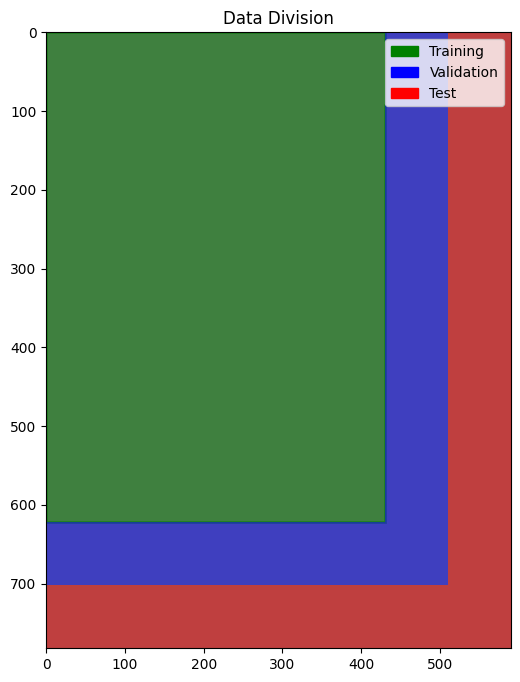

In [14]:
train_image,train_label, test_image, test_label, val_image, val_label=my_division_data(shape=(slice_shape1,slice_shape2), stridetrain=stride, strideval=stride, stridetest=stride)
show_data_division()

Para reduzirmos o efeito da interpolação espacial dos dados de treino nos dados de teste, de modo a aumentar a capacidade de generalização do modelo para dados mais distantes geograficamente, utilizamos duas estratégias. A primeira é a divisão da imagem 3D em inlines e crosslines, que além de permitir o maior aproveitamento dos dados anotados, reduzo efeito da interpolação espacial presente em patchs paralelos. A segunda é uma divisão de dados não aleatória que minimiza as interfaces de contato entre o treino e teste, com uma camada de validação separando as seções.

## Modelo

### Unet

A U-Net é uma arquitetura de rede neural convolucional amplamente utilizada para tarefas de segmentação de imagens, particularmente em contextos médicos e geológicos, devido à sua capacidade de capturar tanto informações locais quanto globais das imagens. A seguir, detalharemos como uma U-Net funciona, e como cada um dos parâmetros escolhidos influencia no funcionamento da rede

#### Estrutura da U-Net
A U-Net consiste em duas partes principais: o caminho de contração (encoder) e o caminho de expansão (decoder). A estrutura básica é formada por:

##### Caminho de Contração (Encoder):

Camadas Convolucionais: A rede começa com uma série de camadas convolucionais que extraem características da imagem de entrada. Cada camada convolucional é seguida por uma função de ativação ReLU (Rectified Linear Unit), que introduz não-linearidade ao modelo, permitindo que ele capture relações complexas entre os pixels.

Max Pooling: Após as camadas convolucionais, uma operação de max pooling é aplicada para reduzir as dimensões da imagem, preservando as características mais importantes e aumentando a robustez da rede em relação a variações e ruídos.
##### Caminho de Expansão (Decoder):

Camadas de Up-Sampling: No caminho de expansão, a imagem é reconstruída para sua resolução original através de operações de up-sampling, que aumentam as dimensões da imagem.

Convoluções Transpostas: Convoluções transpostas (ou convoluções de up-sampling) são usadas para aumentar a resolução da imagem, permitindo a recuperação das características detalhadas necessárias para uma segmentação precisa.

Concatenation: A U-Net incorpora um recurso de atalho que copia e concatena características do caminho de contração com as características correspondentes do caminho de expansão. Isso ajuda a recuperar informações de baixa e alta resolução, melhorando a precisão da segmentação.

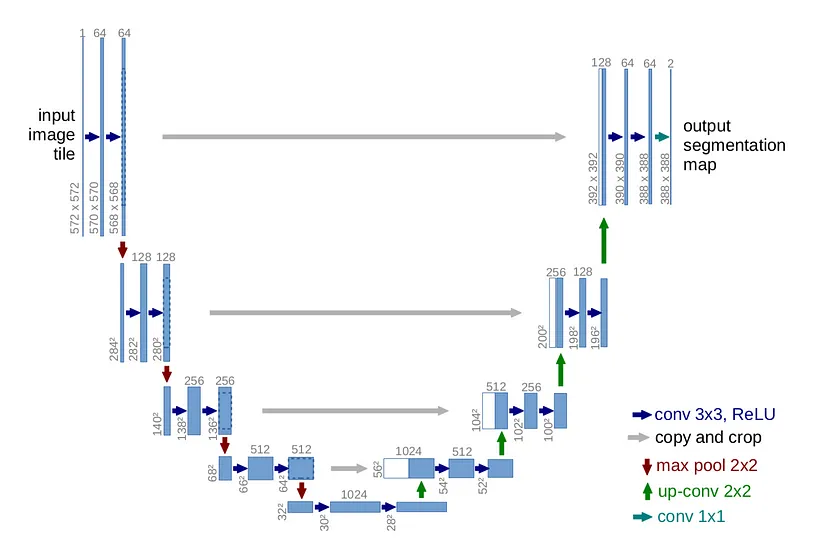

#### Ativação ReLU e Softmax

ReLU (Rectified Linear Unit): A função de ativação ReLU é utilizada após cada camada convolucional. Ela ativa apenas as unidades que têm uma saída positiva, o que ajuda a evitar o problema do gradiente desaparecendo e acelera a convergência do treinamento da rede.

Softmax: A ativação de saída Softmax é aplicada na última camada da U-Net. Ela converte os logit scores em probabilidades que somam 1, facilitando a interpretação dos resultados de segmentação como probabilidades de pertencer a cada classe

#### Implementação

Utilizamos a implementação da Unet da biblioteca [keras-unet-collection](https://github.com/yingkaisha/keras-unet-collection) e optamos pelo uso de 6 camadas, uma vez que através de testes é possível perceber o aumento da capacidade de captura de informações com o aumento da profundidade, de modo que com 6 camadas conseguimos capturar características complexas sems er excessivamente profunda

In [6]:
def Unet(tam_entrada, num_filtros, num_classes):
    model=models.unet_2d(
        input_size=tam_entrada, filter_num=num_filtros, n_labels=num_classes,
        stack_num_down=2, stack_num_up=2, activation="ReLU", output_activation="Softmax",
        batch_norm=True, pool="max",
        name='unet')

    model._name='unet'
    return model

In [7]:
model = Unet(tam_entrada=(slice_shape1, slice_shape2, 1), num_filtros=[16, 32, 64, 128, 256, 512], num_classes=num_classes)

2024-07-17 17:41:21.630029: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 17:41:21.630189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 17:41:21.657165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 992, 192, 1)]        0         []                            
                                                                                                  
 unet_down0_0 (Conv2D)       (None, 992, 192, 16)         144       ['input_1[0][0]']             
                                                                                                  
 unet_down0_0_bn (BatchNorm  (None, 992, 192, 16)         64        ['unet_down0_0[0][0]']        
 alization)                                                                                       
                                                                                                  
 unet_down0_0_activation (R  (None, 992, 192, 16)         0         ['unet_down0_0_bn[0][0]']  

### Callbacks

Para evitarmos treinos excessivamente duradouros que se mantêm após a convergência do modelo utilizamos a técnica de early stopping.

Esse método irá monitorar o calor da perda da validação e caso a melhoria vista seja melhor do que o nosso delta, que é 1e-4, iremos esperar por um número de épocas igual a nossa paciência, que é 15, até finalizarmos a execução do modelo.

Ao terminarmos o treino carregamos o checkpoint que apresentou melhor resultado em relação a acurácia da validação, os quais estão sendo salvos sempre que houver um novo ponto de máximo no treino.

In [9]:
delta=1e-4
patience=15
checkpoint_filepath = './checkpoints/' + FOLDER_NAME + '/checkpoint_'+ NAME + '.weights.h5'

if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

if not os.path.exists('./checkpoints/'+FOLDER_NAME):
    os.makedirs('./checkpoints/'+FOLDER_NAME)

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        min_delta=delta,
        patience=patience,
        verbose=1,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor= "val_acc",
        mode='max',
        save_best_only=True
    )
]

### Parâmetros

O otimizador Adam (Adaptive Moment Estimation) é amplamente reconhecido por sua eficiência e eficácia no treinamento de redes neurais. Uma de suas principais vantagens é a combinação de dois métodos populares: a AdaGrad, que adapta a taxa de aprendizado para cada parâmetro individualmente com base em estimativas de momentos de primeira ordem, e a RMSProp, que usa uma média móvel dos quadrados dos gradientes para normalizar a atualização dos parâmetros. Isso permite ao Adam manter uma taxa de aprendizado adaptativa, que se ajusta dinamicamente ao longo do tempo, melhorando a convergência e reduzindo a necessidade de ajuste manual da taxa de aprendizado

In [11]:
opt=tf.keras.optimizers.Adam(learning_rate=1e-4)


A função de perda Sparse Categorical Crossentropy é amplamente utilizada em problemas de classificação com múltiplas classes, especialmente quando as classes são mutuamente exclusivas. Uma das principais vantagens dessa função de perda é que ela é eficiente em termos de memória e processamento, pois espera que as labels das classes estejam em formato inteiro, em vez de vetores one-hot codificados. Isso simplifica o cálculo e reduz o espaço necessário para armazenar as labels.

In [12]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [13]:
model.compile(optimizer=opt,
                loss=loss,
                metrics=['acc'])

In [14]:
batch_size=16
epochs=100

### Treino

In [15]:
history = model.fit(train_image, train_label, batch_size=batch_size, epochs=epochs,
                        callbacks=callbacks,
                        validation_data=(val_image, val_label)) 

Epoch 1/100


2024-07-17 17:41:26.010802: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-17 17:41:28.013786: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a2a71d81ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-17 17:41:28.013805: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-17 17:41:28.013810: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-17 17:41:28.016551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721238088.068418 2202802 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


344/344 [==============================] - 54s 124ms/step - loss: 0.5339 - acc: 0.8940 - val_loss: 1.1704 - val_acc: 0.6536
Epoch 2/100
344/344 [==============================] - 36s 106ms/step - loss: 0.2447 - acc: 0.9787 - val_loss: 0.4562 - val_acc: 0.8928
Epoch 3/100
344/344 [==============================] - 36s 106ms/step - loss: 0.1598 - acc: 0.9851 - val_loss: 0.3709 - val_acc: 0.9093
Epoch 4/100
344/344 [==============================] - 36s 105ms/step - loss: 0.1125 - acc: 0.9877 - val_loss: 0.3669 - val_acc: 0.9071
Epoch 5/100
344/344 [==============================] - 36s 106ms/step - loss: 0.0837 - acc: 0.9892 - val_loss: 0.3355 - val_acc: 0.9140
Epoch 6/100
344/344 [==============================] - 36s 105ms/step - loss: 0.0655 - acc: 0.9901 - val_loss: 0.3804 - val_acc: 0.9057
Epoch 7/100
344/344 [==============================] - 36s 106ms/step - loss: 0.0524 - acc: 0.9910 - val_loss: 0.3239 - val_acc: 0.9170
Epoch 8/100
344/344 [==============================] - 36s 1

In [16]:
model.load_weights(checkpoint_filepath)

In [17]:
#model.save("/scratch/nunes/seismic_models/TPAM_"+FOLDER_NAME+"_"+NAME+".keras")

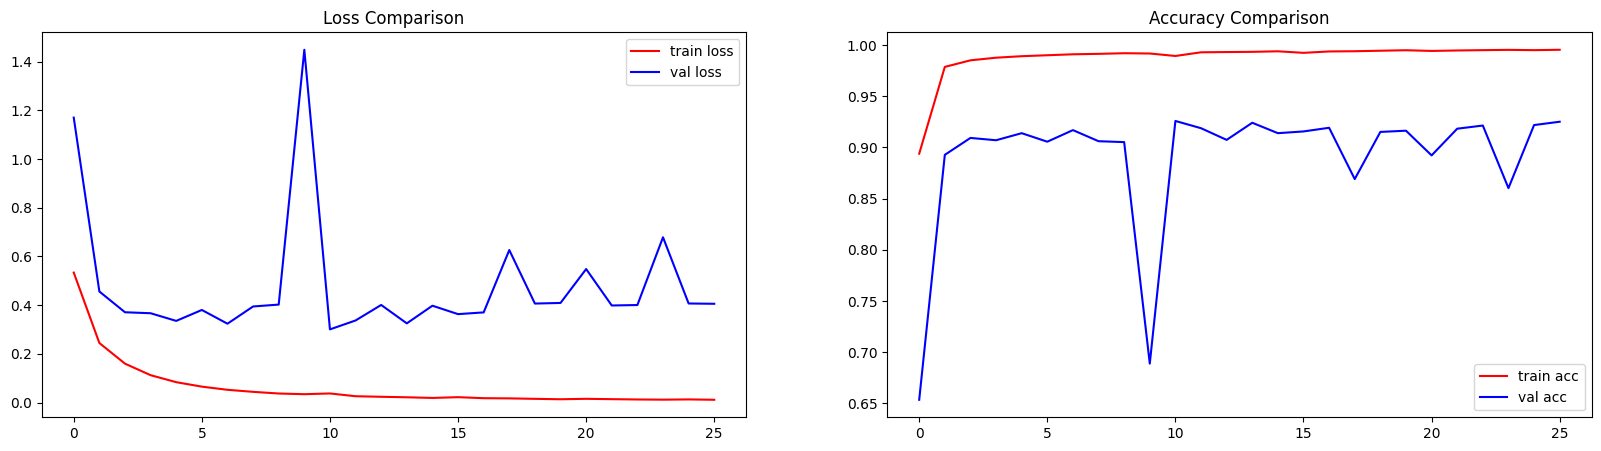

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(history.history["loss"], color='r', label='train loss')
axis[0].plot(history.history["val_loss"], color='b', label='val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(history.history["acc"], color='r', label='train acc')
axis[1].plot(history.history["val_acc"], color='b', label='val acc')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()
plt.grid(False)
plt.show()

In [19]:
if not os.path.exists('./models'):
    os.makedirs('./models')
model.save("./models/" + FOLDER_NAME +"_"+ NAME +".keras")

## Explicabilidade

### Funções auxiliares

In [17]:
def heatmap_image(heatmap):
    heatmap = heatmap.squeeze()
    heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())  # Normalizando o heatmap entre 0 e 1
    return heatmap_normalized

In [18]:
def visualize_prediction(image, true_mask, predicted_mask):
    true_mask=true_mask.squeeze()
    fig, axes = plt.subplots(1, 3, figsize=(5, 5), sharey=True)

    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    accuracy = np.mean(true_mask == predicted_mask) * 100
    class_colors = plt.cm.viridis(np.linspace(0, 1, num_classes))[:, :3]
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]

    #Ground Truth
    overlay_true_mask = np.zeros(image.squeeze().shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_true_mask[true_mask == cls] = color
    axes[1].imshow(overlay_true_mask)
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    #Prediction
    overlay_predicted_mask = np.zeros(image.squeeze().shape + (3,), dtype=np.float32)
    for cls, color in enumerate(class_colors):
        overlay_predicted_mask[predicted_mask == cls] = color
    axes[2].imshow(overlay_predicted_mask)
    axes[2].set_title(f"Prediction\nAccuracy: {accuracy:.2f}%")
    axes[2].axis('off')


    #Legend
    legend_axe = axes[0]
    legend_axe.axis('off')
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for color, label in zip(class_colors, class_labels)]
    legend_axe.legend(handles=legend_elements, loc='lower left')

In [19]:
def visualize_gradcam(image, true_mask, predicted_mask):
    true_mask=true_mask.squeeze()
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 5), sharey=True)

    predicted_mask = np.argmax(predicted_mask[0], axis=-1)
    class_colors = plt.cm.viridis(np.linspace(0, 1, 6))[:, :3]
    class_labels = [f'Classe {cls}' for cls in range(len(class_colors))]


    #Activations
    for target_class in range(0,num_classes):
        heatmap=compute_gradcam(image, target_class).numpy()
        heat_img=heatmap_image(heatmap)
        im = axes[target_class].imshow(heat_img)
        axes[target_class].set_title(f"Class {target_class}")
        axes[target_class].axis('off')
    
    fig.colorbar(im, ax=axes, orientation='horizontal', shrink=0.8,format='')

### Grad-Cam


Grad-CAM (Gradient-weighted Class Activation Mapping) é uma técnica de visualização utilizada para interpretar e entender as decisões tomadas por redes neurais convolucionais (CNNs). Ele destaca as regiões da imagem de entrada que são mais importantes para a predição de uma determinada classe, fornecendo uma explicação visual sobre quais partes da imagem influenciaram a decisão do modelo.

O funcionamento do Grad-CAM envolve os seguintes passos:

1. Cálculo dos Gradientes: Primeiro, calcula-se o gradiente da pontuação da classe alvo em relação às ativações de uma camada convolucional específica. Esses gradientes indicam a importância das ativações para a classe alvo.

2. Ponderação das Ativações: Em seguida, os gradientes são globalmente agregados (geralmente por média) para obter um peso para cada canal de ativação da camada convolucional. 
Esses pesos refletem a importância de cada canal para a predição da classe alvo.

3. Geração do Mapa de Ativação: Os pesos calculados são então usados para ponderar as ativações da camada convolucional, resultando em um mapa de ativação ponderado.

4. Visualização do Grad-CAM: O mapa de ativação ponderado é finalmente passado por uma ReLU (para manter apenas os valores positivos) e redimensionado para as dimensões da imagem original. Isso produz uma visualização em forma de mapa de calor que destaca as regiões mais relevantes da imagem para a decisão do modelo.

Grad-CAM é valioso porque oferece insights sobre o comportamento interno das CNNs, ajudando a identificar quais características da imagem são mais influentes nas previsões, facilitando a interpretação e a explicação das decisões do modelo.

In [20]:
LAYER_NAME='unet_output'

Escolhemos a última camada convolucional para o uso do Grad-CAM por 3 motivos:

1. Equilíbrio entre Abstração e Detalhe: A última camada convolucional captura características de alto nível que são diretamente relevantes para a decisão do modelo, mantendo ao mesmo tempo informações espaciais detalhadas da imagem. 

2. Resolução Adequada: Ao contrário das camadas totalmente conectadas ou de saída, a última camada convolucional preserva uma resolução espacial que é suficiente para identificar áreas específicas da imagem, facilitando a visualização das regiões mais influentes para a predição.

3. Informações Ricas em Características: Esta camada combina informações extraídas de todas as camadas anteriores, fornecendo um mapa de ativação que reflete uma combinação rica de características importantes para a classe de interesse.

In [21]:
class GradCAMModel(tf.keras.Model):
    def __init__(self, model, conv_layer_name):
        super(GradCAMModel, self).__init__()
        self.segmentation_model = model
        self.extractor = tf.keras.Model(inputs=model.inputs, outputs=[model.get_layer(conv_layer_name).output])

    def call(self, x):
        feature_map = self.extractor(x)
        return feature_map

gradcam_model = GradCAMModel(model, LAYER_NAME)

# Defina uma função para calcular os gradientes com relação ao mapa de ativação da classe
@tf.function
def compute_gradcam(image, class_idx):
    with tf.GradientTape() as tape:
        feature_map = gradcam_model(image)
        loss = tf.reduce_mean(feature_map[:, :, :, class_idx])

    grads = tape.gradient(loss, feature_map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, feature_map), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    # Retorna o mapa de calor Grad-CAM como um tensor TensorFlow
    return heatmap


### Visualização

In [22]:
img_pos=100
image=test_image[img_pos:img_pos+1,:,:]
label=test_label[img_pos:img_pos+1,:,:]
predicted_label=model.predict(image)

2024-07-19 13:21:57.936098: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 1s 675ms/step


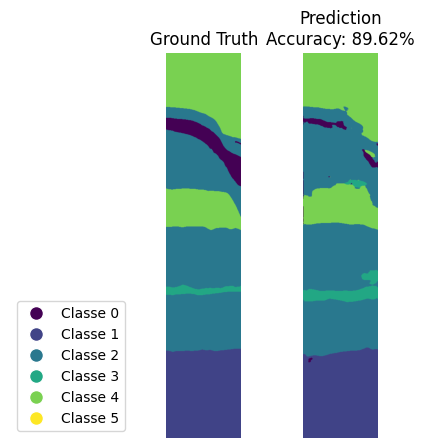

In [23]:
visualize_prediction(image,label,predicted_label)

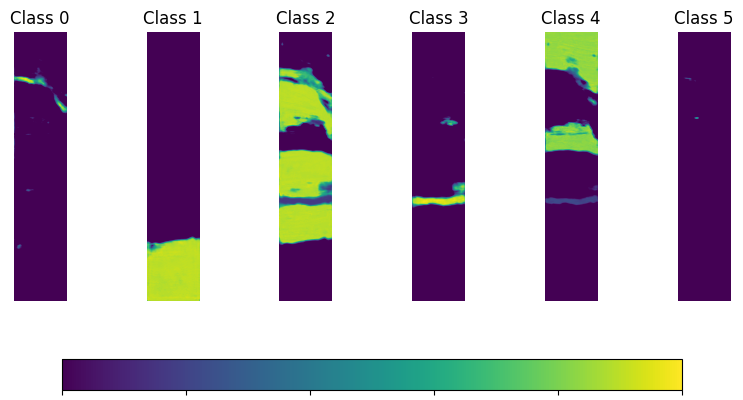

In [24]:
visualize_gradcam(image,label,predicted_label)

## Resultados

### Funções Auxiliares

In [27]:
def seisfacies_predict(model, test_image): 
    predictions=[]
    for image in range(0,test_image.shape[0], 100):
        limit=np.min([test_image.shape[0], (image+100)])
        prediction=model.predict(test_image[image:limit], verbose=0)
        prediction=np.argmax(prediction, axis=3)
        if image==0:
            predictions=prediction
        else:
            predictions=np.append(predictions, prediction, axis=0)
    return predictions
        
def calculate_accuracy(model, test_image, test_label):
    return model.evaluate(test_image, test_label)[1]

def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    micro_precision = true_positives / (true_positives + false_positives)
    micro_recall = true_positives / (true_positives + false_negatives)
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    return micro_f1_score

def calculate_class_info(test_label, num_classes, predicted_label):
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for class_idx in range(num_classes):
        true_positive_mask = (predicted_label == class_idx) & (test_label == class_idx)
        false_positive_mask = (predicted_label == class_idx) & (test_label != class_idx)
        false_negative_mask = (predicted_label != class_idx) & (test_label == class_idx)

        true_positives[class_idx] += true_positive_mask.sum().item()
        false_positives[class_idx] += false_positive_mask.sum().item()
        false_negatives[class_idx] += false_negative_mask.sum().item()

    accuracy_by_class = {}
    for class_idx in range(num_classes):
        total_pixels = true_positives[class_idx] + false_positives[class_idx] + false_negatives[class_idx]
        if true_positives[class_idx]!=0:
            accuracy_by_class[class_idx] = true_positives[class_idx] / total_pixels
            precision = true_positives[class_idx] / (true_positives[class_idx] + false_positives[class_idx])
            recall = true_positives[class_idx] / (true_positives[class_idx] + false_negatives[class_idx])
        else:
            accuracy_by_class[class_idx]=0
            precision=0
            recall=0
        accuracy_by_class[class_idx] = [
            accuracy_by_class[class_idx],
            precision,
            recall
        ]

    total_true_positives = sum(true_positives)
    total_false_positives = sum(false_positives)
    total_false_negatives = sum(false_negatives)

    micro_f1_score = calculate_micro_f1_score(total_true_positives, total_false_positives, total_false_negatives)

    return accuracy_by_class, micro_f1_score

def calculate_macro_f1_score(class_info, num_classes=6):
    class_f1 = list(range(0,num_classes))
    for class_idx in class_info:
        precision = class_info[class_idx][1]
        recall = class_info[class_idx][2]
        if(precision+recall!=0):
            class_f1[class_idx] = 2 * (precision * recall) / (precision + recall)
        else:
            class_f1[class_idx]=0

    macro_f1_score = np.mean(list(class_f1))

    return macro_f1_score, class_f1

### Métricas

Utilizamos 4 métricas para analisarmos o desempenho do modelo para cada uma das classes:
- Acurácia: Proporção de previsões corretas (verdadeiros positivos e verdadeiros negativos) em relação ao total de previsões.

- Precisão: Proporção de verdadeiros positivos em relação ao total de previsões positivas. Mede a qualidade das previsões positivas.

- Recall (Sensibilidade): Proporção de verdadeiros positivos em relação ao total de positivos reais. Mede a capacidade de identificar todos os positivos.

- F1 Score: Média harmônica entre precisão e recall, balanceando ambos. Útil quando há um trade-off entre precisão e recall.

Além disso, utilizamos duas métricas para analisarmos o desempenho do modelo como um todo:
- Acurácia
- Macro F1: Considera todas as classes igualmente e calcula a média dos F1 Scores individuais de cada classe, o que é muito util para dados com distribuição desigual das classes

In [28]:

predicted_label = seisfacies_predict(model,test_image)
class_info, acc=calculate_class_info(test_label, num_classes, predicted_label)
macro_f1, class_f1=calculate_macro_f1_score(class_info, num_classes)

data=[]
for i in range(len(class_info)):
    data.append(["Classe "+str(i)] + class_info[i]+[class_f1[i]])


#define header names
col_names = ["Classe","Accuracy", "Precision", 'Recall', 'F1 score']
print(tabulate(data, headers=col_names, tablefmt="fancy_grid",floatfmt=".4f"))
print("Macro F1 "+ str(macro_f1) + "\nAcurácia " + str(acc))


╒══════════╤════════════╤═════════════╤══════════╤════════════╕
│ Classe   │   Accuracy │   Precision │   Recall │   F1 score │
╞══════════╪════════════╪═════════════╪══════════╪════════════╡
│ Classe 0 │     0.4416 │      0.7933 │   0.4990 │     0.6126 │
├──────────┼────────────┼─────────────┼──────────┼────────────┤
│ Classe 1 │     0.8984 │      0.9840 │   0.9117 │     0.9465 │
├──────────┼────────────┼─────────────┼──────────┼────────────┤
│ Classe 2 │     0.6891 │      0.7602 │   0.8806 │     0.8159 │
├──────────┼────────────┼─────────────┼──────────┼────────────┤
│ Classe 3 │     0.3686 │      0.4187 │   0.7549 │     0.5386 │
├──────────┼────────────┼─────────────┼──────────┼────────────┤
│ Classe 4 │     0.7837 │      0.9396 │   0.8252 │     0.8787 │
├──────────┼────────────┼─────────────┼──────────┼────────────┤
│ Classe 5 │     0.1822 │      0.2547 │   0.3905 │     0.3083 │
╘══════════╧════════════╧═════════════╧══════════╧════════════╛
Macro F1 0.6834504231517284
Acurácia 0.8


Os resultados apresentados mostram um desempenho variável do modelo entre as diferentes classes, refletindo a diversidade na precisão e no recall para cada uma delas. A Classe 1 e a Classe 4 têm o melhor desempenho geral, com altas métricas de precisão, recall e F1 score, indicando que o modelo faz um bom trabalho em identificar e classificar corretamente essas classes. Em contraste, a Classe 5, que constitui apenas 1% do dataset, exibe o pior desempenho, com métricas significativamente baixas de precisão, recall e F1 score. Isso é esperado, dado que a baixa representação de uma classe geralmente resulta em menos amostras para o modelo aprender, levando a uma pior performance.

A Classe 3, representando 4% do dataset, também mostra resultados abaixo da média, especialmente em acurácia, refletindo dificuldades em classificar corretamente essa classe. O Macro F1 Score de aproximadamente 0.683 e a acurácia global de 0.825 sugerem que, embora o modelo tenha um desempenho razoável em média, há um desafio significativo na detecção de classes menos representadas. A discrepância nas métricas entre as classes mais frequentes e as menos frequentes destaca a necessidade de estratégias para lidar com o desequilíbrio de classes, como técnicas de reamostragem ou ajustes de pesos.